# Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

**This notebook contains code for Image Classification using AWS SageMaker project. In this project pretrained ResNet50 model from Pytorch was used to perform transfer learning on the dog breed classication dataset provided by Udacity. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets. Sagemaker hyperparameter tuning, profiling, and debugging were used to train the model. After training, the model was deployed to a SageMaker endpoint and queried with a sample image to get prediciton.**

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [4]:
!pip install torchvision --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 23.3 MB 23.8 MB/s            
     |████████████████████████████████| 881.9 MB 76.9 MB/s            


In [6]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import json
import boto3
import glob
import io
import IPython
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import numpy as np
import os
from PIL import Image
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

[2021-12-16 20:12:56.754 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [7]:
sess = sagemaker.Session()
bucket= sess.default_bucket()
print("Default Bucket: {}".format(bucket))
region = sess.boto_region_name
print("AWS Region: {}".format(region))
role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-005262646839
AWS Region: us-east-1
RoleArn: arn:aws:iam::005262646839:role/service-role/AmazonSageMaker-ExecutionRole-20211213T132830


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

**The dog breed classification dataset containing images from 133 dog breeds divided into training, testing and validation datasets from Udacity was used for this project.**

In [5]:
#TODO: Fetch and upload the data to AWS S3
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [7]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/project3/dogImages

In [8]:
print(len(glob.glob('dogImages/train/*/*')))
print(len(glob.glob('dogImages/valid/*/*')))
print(len(glob.glob('dogImages/test/*/*')))

6680
835
836


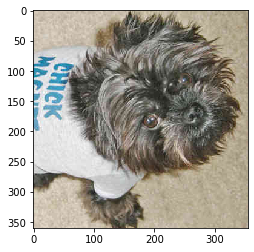

In [20]:
# Looking at some sample pictures in the dataset

img = plt.imread('dogImages/train/001.Affenpinscher/Affenpinscher_00008.jpg')
plt.imshow(img);

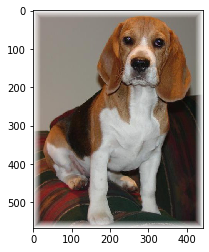

In [21]:
img = plt.imread('dogImages/test/016.Beagle/Beagle_01196.jpg')
plt.imshow(img);

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

**I used learning rate and batch size for hyperparameter tuning.**

In [22]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
}

In [23]:
#TODO: Create estimators for your HPs
# TODO: Your estimator here

estimator = PyTorch(
    entry_point="/root/project3/hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
)

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]
# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [27]:
# TODO: Fit your HP Tuner
# TODO: Remember to include your data channels

os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-005262646839/project3/dogImages/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-005262646839/project3/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-005262646839/project3/output/'

In [28]:
tuner.fit({'training': 's3://sagemaker-us-east-1-005262646839/project3/dogImages/'}, wait=True)

.........................................................................................................................................................................................................................................................!


In [29]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-16 20:45:14 Starting - Preparing the instances for training
2021-12-16 20:45:14 Downloading - Downloading input data
2021-12-16 20:45:14 Training - Training image download completed. Training in progress.
2021-12-16 20:45:14 Uploading - Uploading generated training model
2021-12-16 20:45:14 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.0014103036592105808',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-16-20-25-12-684"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-25-12-684/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

**Using hyperparameters from the best training job**

In [30]:
# TODO: Set up debugging and profiling rules and hooks

hyperparameters = {"batch_size": 32, "lr": 0.0014103036592105808}

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1))

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",
                                     parameters={"include_regex": "CrossEntropyLoss_output_0",
                                                 "train.save_interval": "10",
                                                 "eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig(collection_configs=collection_configs)

In [31]:
# TODO: Create and fit an estimator
# TODO: Your estimator here

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="/root/project3/train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [32]:
estimator.fit({'training': 's3://sagemaker-us-east-1-005262646839/project3/dogImages/'}, wait=True)

2021-12-16 20:51:50 Starting - Starting the training job...
2021-12-16 20:51:59 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-16 20:53:10 Starting - Preparing the instances for training......
2021-12-16 20:54:18 Downloading - Downloading input data.........
2021-12-16 20:55:51 Training - Downloading the training image..................
2021-12-16 20:58:50 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-16 20:58:51,325 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-16 20:58:51,344 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-16 20:58:54,367 sagemaker_pytorch_container.t

In [35]:
# TODO: Plot a debugging output.

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print()
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print()
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2021-12-16-20-51-50-086

[2021-12-16 21:07:19.719 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-51-50-086/debug-output
[2021-12-16 21:07:23.536 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-16 21:07:24.555 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_

In [36]:
# plot the loss curve

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals

In [37]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")
    
    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data


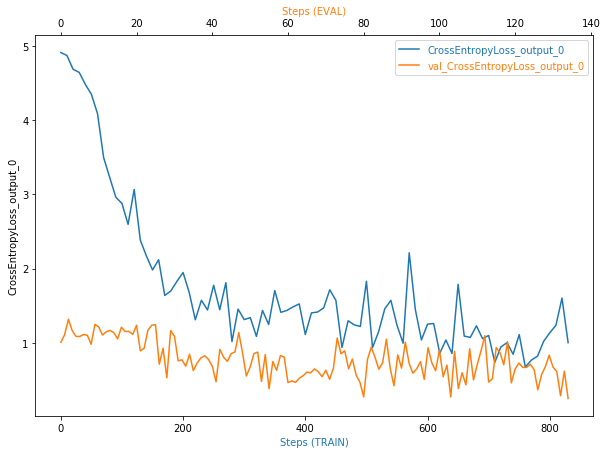

In [38]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

**According to debugger some issues were detected during training:**
- Overtraining: IssuesFound
- PoorWeightInitialization: IssuesFound
- LowGPUUtilization: IssuesFound

**To address these problems automated actions can be set up (e.g. stop a training job, send notifications parameters)**  

In [39]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-51-50-086/rule-output


In [40]:
! aws s3 ls {rule_output_path} --recursive

2021-12-16 21:06:36     437018 pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-16 21:06:35     295745 pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-16 21:06:31        567 pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-16 21:06:31      16886 pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-16 21:06:31       1835 pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-16 21:06:31        327 pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-16 21:06:31       5674 pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-re

In [41]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-51-50-086/rule-output/ProfilerRepor

In [42]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [43]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [45]:
# TODO: Deploy your model to an endpoint
# TODO: Add your deployment configuration like instance type and number of instances

predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

----------!

In [52]:
model_data = estimator.model_data
print(model_data)
model = PyTorchModel(model_data=model_data, role=role, entry_point="/root/project3/test.py", py_version="py36", framework_version="1.8") 

s3://sagemaker-us-east-1-005262646839/pytorch-training-2021-12-16-20-51-50-086/output/model.tar.gz


In [88]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [91]:
# TODO: Run an prediction on the endpoint
# TODO: Your code to load and preprocess image to send to endpoint for prediction

with open("/root/project3/Shelter.jpg", 'rb') as f:
    img = f.read()

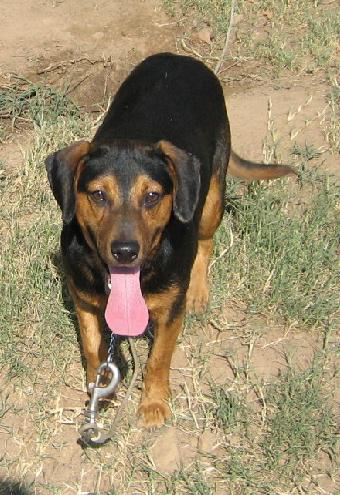

In [92]:
Image.open(io.BytesIO(img))

In [93]:
runtime = boto3.client('runtime.sagemaker')
resp = runtime.invoke_endpoint(EndpointName = predictor.endpoint_name,
                               ContentType = 'image/png',
                               Body = img)  

pred = json.loads(resp['Body'].read().decode())

In [94]:
print(pred)

[[-11.313297271728516, -9.70058822631836, -4.449568748474121, -4.706109046936035, -8.783914566040039, -12.307699203491211, -1.3359037637710571, -2.29974365234375, -2.457489013671875, -2.6270945072174072, 0.6494631767272949, -4.026546955108643, -2.851837635040283, -0.9963968992233276, -6.482645034790039, -4.162182807922363, -11.707833290100098, -0.28981661796569824, -11.138080596923828, -2.0989890098571777, -9.717801094055176, -8.281536102294922, -4.047097206115723, -12.709068298339844, -4.448675632476807, -9.574467658996582, -3.9614291191101074, -2.8864352703094482, -9.014554023742676, -1.593833327293396, -10.852490425109863, -5.4856085777282715, -8.975927352905273, -3.3301773071289062, -7.112125873565674, -8.751749992370605, -4.056046485900879, -9.061806678771973, -7.240837097167969, -5.60062837600708, -2.7945308685302734, -8.006608009338379, -3.5151774883270264, -3.9861011505126953, -2.4481630325317383, -7.220778942108154, -0.36784467101097107, -4.797989845275879, -8.603877067565918,

In [95]:
np.argmax(pred[0])

10

In [96]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()